Copyright (c) Eon Systems, 2025.
All rights reserved. Unauthorized copying, distribution, or modification of this file, in whole or in part, is strictly prohibited.

# P9s to simulate forward walking

In [1]:
import torch
import pandas as pd
import pickle
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
import src.utils as utils
import src.models as models
warnings.filterwarnings('ignore', '.*Sparse CSR tensor support is in beta state.*')

config_dirs = {
    'path_res': '../results/torch_data/',      # directory to store results
    'path_comp': '../data/Completeness_783.csv',    # csv of the complete list of FlyWire neurons
    'path_conn': '../data/Connectivity_783.parquet', # connectivity data
    'path_wt': '../data', # weight directory
}

List all of our output neurons. These are the neuron IDs of the descending neurons that we care about. These descending neurons may be used to control the body of the fly

In [2]:
flyid2name = { }
#P9_oDN1 corresponds to forward velocity
P9_oDN1_left = 720575940626730883
P9_oDN1_right = 720575940620300308
P9_left = 720575940627652358
P9_right =720575940635872101
#DNa01 and DNa02 correspond to turning
DNa01_right = 720575940627787609
DNa01_left = 720575940644438551
DNa02_right = 720575940629327659
DNa02_left = 720575940604737708
#MDN, "Moonwalker descending neurons" are backwards walking/escape/startle response
MDN_1, MDN_2, MDN_3, MDN_4 = 720575940616026939, 720575940631082808,720575940640331472,720575940610236514
#Giant Fiber corresponds to escape
Giant_Fiber_1, Giant_Fiber_2 = 720575940622838154,720575940632499757
#MN9 corresponds to proboscis motor neuron, and corresponds to feeding.
MN9_left = 720575940660219265
MN9_right = 720575940618238523
#aDN1 correspond to antennal grooming
aDN1_right = 720575940616185531
aDN1_left = 720575940624319124


flyid2name[P9_oDN1_left]=       "P9_oDN1_left"
flyid2name[P9_oDN1_right]=      "P9_oDN1_right"
flyid2name[P9_left]=    "P9_left"
flyid2name[P9_right]=   "P9_right"
flyid2name[DNa01_right]=        "DNa01_right"
flyid2name[DNa01_left]= "DNa01_left"
flyid2name[DNa02_right]=        "DNa02_right"
flyid2name[DNa02_left]= "DNa02_left"
flyid2name[MDN_1]= "MDN_1"
flyid2name[MDN_2]= "MDN_2"
flyid2name[MDN_3]= "MDN_3"
flyid2name[MDN_4]= "MDN_4"
flyid2name[Giant_Fiber_1]= "Giant_Fiber_1"
flyid2name[Giant_Fiber_2]= "Giant_Fiber_2"
flyid2name[MN9_left]= "MN9_left"
flyid2name[MN9_right]= "MN9_right"
flyid2name[aDN1_right]= "aDN1_right"
flyid2name[aDN1_left]= "aDN1_left"

In [3]:
output_neurons = [P9_oDN1_left, P9_oDN1_right, DNa01_right, DNa01_left, DNa02_right, DNa02_left, MDN_1, MDN_2, MDN_3, MDN_4, Giant_Fiber_1, Giant_Fiber_2, MN9_left, MN9_right, aDN1_right, aDN1_left]

In [4]:
stim_rate = 100
P9s = [P9_left, P9_right]
flyid2i, i2flyid = utils.get_hash_tables(config_dirs['path_comp'])

In [5]:
excitatory_neurons = [flyid2i[n] for n in P9s]

In [6]:
weights = utils.get_weights(config_dirs['path_conn'], config_dirs['path_comp'], config_dirs['path_wt'])

In [7]:
sim_params = {
    'dt': 0.1,               # time step (ms)
    't_sim': 1000.0,         # total simulation time (ms)
    'batch_size': 30,        # batch size
}

model_params = {
    'tauSyn': 5.0,    # ms
    'tDelay': 1.8,    # ms
    'v0': -52.0,      # mV
    'vReset': -52.0,  # mV
    'vRest': -52.0,   # mV
    'vThreshold': -45.0,  # mV
    'tauMem': 20.0,   # ms
    'tRefrac': 2.2,    # ms
    'scalePoisson': 250, # scaling factor for poisson input
    'wScale': 0.275,      # scaling factor for synaptic weights
}

In [8]:
rates = torch.zeros(sim_params['batch_size'],len(flyid2i))
rates[:,excitatory_neurons] = stim_rate

In [9]:
device = 'cuda'
num_steps = int(sim_params['t_sim'] / sim_params['dt'])
model = models.TorchModel(sim_params['batch_size'], weights.shape[0], sim_params['dt'], model_params, weights.to(device=device), device=device)
conductance, delay_buffer, spikes, v, refrac = model.state_init()
rates = rates.to(device=device)
spike_times = torch.tensor([], device=device)
spike_idx = torch.tensor([], device=device, dtype=torch.int32)
generator = torch.Generator(device=device).manual_seed(42)

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

Used 3.7052 GB


In [10]:
generator = torch.Generator(device=device).manual_seed(42)

with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    times_list = []
    idx_list = []
    for b in range(sim_params['batch_size']):
        times_list.append(torch.tensor([], device=device))
        idx_list.append(torch.tensor([], device=device))
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)
        for b in range(sim_params['batch_size']):
            times_list[b], idx_list[b] = utils.get_spike_times(spikes[b,:], t, sim_params['dt'], times_list[b], idx_list[b])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation time: 174.37 seconds


Used 4.3022 GB


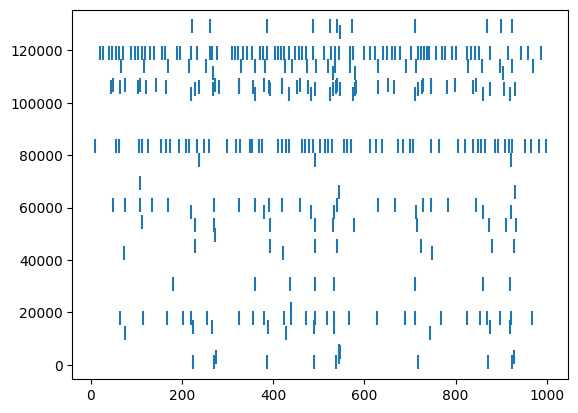

In [11]:
plt.figure()
plt.scatter(times_list[0].cpu(), idx_list[0].cpu(), s=100, marker='|')

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

In [12]:
df = utils.construct_dataframe(times_list, idx_list, i2flyid, 'P9s_100Hz_b', sim_params['dt'])
df.to_parquet(config_dirs['path_res']+'P9s_100Hz_b.parquet', compression='brotli')

In [13]:
df_spike = utils.load_exps([config_dirs['path_res']+'P9s_100Hz_b.parquet',])
df_rate, df_rate_std = utils.get_rate(df_spike, t_run=1.0, n_run=sim_params['batch_size'], flyid2name=flyid2name)
df_rate.sort_values('P9s_100Hz_b', ascending=False, inplace=True)
df_rate

exp_name,name,P9s_100Hz_b
flyid,,
720575940635872101,P9_right,66.866667
720575940627652358,P9_left,66.533333
720575940613626521,,29.200000
720575940633901395,,23.766667
720575940631924584,,17.100000
...,...,...
720575940645693988,,0.033333
720575940622027222,,0.033333
720575940618445497,,0.033333


In [14]:
relevant_neurons = [neuron for neuron in output_neurons if neuron in df_rate.index]
display(df_rate.loc[relevant_neurons])

exp_name,name,P9s_100Hz_b
flyid,,
720575940626730883,P9_oDN1_left,6.133333
720575940620300308,P9_oDN1_right,1.633333
720575940629327659,DNa02_right,0.633333
720575940604737708,DNa02_left,10.166667


# Labellar sugar GRNs

In [15]:
sugar_GRNs = [720575940616885538,720575940630233916,720575940639332736,720575940632889389,720575940617000768,720575940632425919,720575940637568838,720575940629176663,720575940621502051,720575940638202345,720575940612670570,720575940611875570,720575940621754367,720575940633143833,720575940613601698,720575940630797113,720575940639198653,720575940639259967,720575940624963786,720575940640649691,720575940610788069,720575940623172843,720575940628853239]

stim_rate = 200.0
rates = torch.zeros(sim_params['batch_size'],len(flyid2i), device=device)
excitatory_neurons = [flyid2i[n] for n in sugar_GRNs]
rates[:,excitatory_neurons] = stim_rate

model = models.TorchModel(sim_params['batch_size'], weights.shape[0], sim_params['dt'], model_params, weights.to(device=device), device=device)
conductance, delay_buffer, spikes, v, refrac = model.state_init()
spike_times = torch.tensor([], device=device)
spike_idx = torch.tensor([], device=device, dtype=torch.int32)
generator = torch.Generator(device=device).manual_seed(42)

with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    times_list = []
    idx_list = []
    for b in range(sim_params['batch_size']):
        times_list.append(torch.tensor([], device=device))
        idx_list.append(torch.tensor([], device=device))
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)
        for b in range(sim_params['batch_size']):
            times_list[b], idx_list[b] = utils.get_spike_times(spikes[b,:], t, sim_params['dt'], times_list[b], idx_list[b])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation time: 180.25 seconds


Used 4.2280 GB


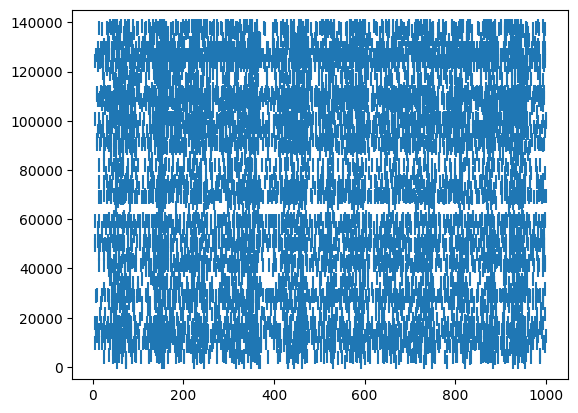

In [16]:
plt.figure()
plt.scatter(times_list[0].cpu(), idx_list[0].cpu(), s=100, marker='|')

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

In [17]:
df = utils.construct_dataframe(times_list, idx_list, i2flyid, 'Sugar_200Hz', sim_params['dt'])
df.to_parquet(config_dirs['path_res']+'Sugar_200Hz.parquet', compression='brotli')

In [18]:
ps = [
    config_dirs['path_res']+'P9s_100Hz_b.parquet',
    config_dirs['path_res']+'Sugar_200Hz.parquet',
]

df_spike = utils.load_exps(ps)
df_rate, df_rate_std = utils.get_rate(df_spike, t_run=1.0, n_run=sim_params['batch_size'], flyid2name=flyid2name)
df_rate.sort_values('P9s_100Hz_b', ascending=False, inplace=True)
df_rate

exp_name,name,P9s_100Hz_b,Sugar_200Hz
flyid,,,
720575940635872101,P9_right,66.866667,NaN
720575940627652358,P9_left,66.533333,NaN
720575940613626521,,29.200000,NaN
720575940633901395,,23.766667,NaN
720575940631924584,,17.100000,NaN
...,...,...,...
720575940660219265,MN9_left,NaN,64.800000
720575940660220289,,NaN,0.400000
720575940660223873,,NaN,38.733333


In [19]:
relevant_neurons = [neuron for neuron in output_neurons if neuron in df_rate.index]
display(df_rate.loc[relevant_neurons])

exp_name,name,P9s_100Hz_b,Sugar_200Hz
flyid,,,
720575940626730883,P9_oDN1_left,6.133333,NaN
720575940620300308,P9_oDN1_right,1.633333,NaN
720575940644438551,DNa01_left,NaN,0.066667
720575940629327659,DNa02_right,0.633333,NaN
720575940604737708,DNa02_left,10.166667,NaN
720575940660219265,MN9_left,NaN,64.800000
720575940618238523,MN9_right,NaN,47.700000


# Add Bitter Neurons

In [20]:
bitter_GRNs = [720575940619072513,720575940646212996,720575940622298631,720575940642088333,720575940627692048,720575940617239197,720575940618682526,
               720575940604714528,720575940603266592,720575940604027168,720575940619197093,720575940610259370,720575940627578156,720575940629481516,
               720575940618887217,720575940614281266,720575940634859188,720575940645743412,720575940637742911,720575940617094208,720575940629416318,
               720575940630195909,720575940615641798,720575940638312262,720575940624310345,720575940621778381,720575940619659861,720575940629146711,
               720575940625750105,720575940610483162,720575940610481370,720575940602353632,720575940610773090,720575940617433830,720575940628962407,
               720575940626287336,720575940623183083,720575940618025199,720575940619028208,720575940621864060,720575940613061118,720575940621008895,
               ]
for i, neuron_id in enumerate(bitter_GRNs):
    flyid2name[neuron_id] = f"bitter_GRN_{i+1}"

In [21]:
rates = torch.zeros(sim_params['batch_size'],len(flyid2i), device=device)
excitatory_neurons = [flyid2i[n] for n in sugar_GRNs]
rates[:,excitatory_neurons] = stim_rate
excitatory_neurons2 = [flyid2i[n] for n in bitter_GRNs]
rates[:,excitatory_neurons2] = stim_rate

model = models.TorchModel(sim_params['batch_size'], weights.shape[0], sim_params['dt'], model_params, weights.to(device=device), device=device)
conductance, delay_buffer, spikes, v, refrac = model.state_init()
spike_times = torch.tensor([], device=device)
spike_idx = torch.tensor([], device=device, dtype=torch.int32)
generator = torch.Generator(device=device).manual_seed(42)

with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    times_list = []
    idx_list = []
    for b in range(sim_params['batch_size']):
        times_list.append(torch.tensor([], device=device))
        idx_list.append(torch.tensor([], device=device))
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)
        for b in range(sim_params['batch_size']):
            times_list[b], idx_list[b] = utils.get_spike_times(spikes[b,:], t, sim_params['dt'], times_list[b], idx_list[b])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation time: 178.53 seconds


Used 4.1948 GB


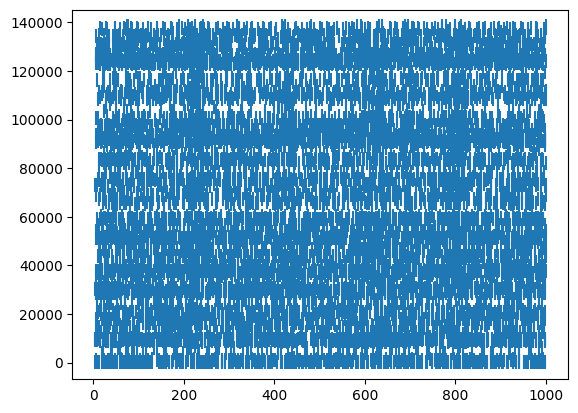

In [22]:
plt.figure()
plt.scatter(times_list[0].cpu(), idx_list[0].cpu(), s=100, marker='|')

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

In [23]:
df = utils.construct_dataframe(times_list, idx_list, i2flyid, 'Sugar_and_bitter', sim_params['dt'])
df.to_parquet(config_dirs['path_res']+'Sugar_and_bitter.parquet', compression='brotli')
ps = [
    config_dirs['path_res']+'P9s_100Hz_b.parquet',
    config_dirs['path_res']+'Sugar_200Hz.parquet',
    config_dirs['path_res']+'Sugar_and_bitter.parquet',
]

df_spike = utils.load_exps(ps)
df_rate, df_rate_std = utils.get_rate(df_spike, t_run=1.0, n_run=sim_params['batch_size'], flyid2name=flyid2name)
df_rate.sort_values('P9s_100Hz_b', ascending=False, inplace=True)
df_rate

exp_name,name,P9s_100Hz_b,Sugar_200Hz,Sugar_and_bitter
flyid,,,,
720575940635872101,P9_right,66.866667,NaN,NaN
720575940627652358,P9_left,66.533333,NaN,NaN
720575940613626521,,29.200000,NaN,NaN
720575940633901395,,23.766667,NaN,NaN
720575940631924584,,17.100000,NaN,NaN
...,...,...,...,...
720575940660219265,MN9_left,NaN,64.800000,0.100000
720575940660220289,,NaN,0.400000,NaN
720575940660223873,,NaN,38.733333,8.066667


In [24]:
relevant_neurons = [neuron for neuron in output_neurons if neuron in df_rate.index]
display(df_rate.loc[relevant_neurons])

exp_name,name,P9s_100Hz_b,Sugar_200Hz,Sugar_and_bitter
flyid,,,,
720575940626730883,P9_oDN1_left,6.133333,NaN,NaN
720575940620300308,P9_oDN1_right,1.633333,NaN,NaN
720575940644438551,DNa01_left,NaN,0.066667,NaN
720575940629327659,DNa02_right,0.633333,NaN,NaN
720575940604737708,DNa02_left,10.166667,NaN,NaN
720575940660219265,MN9_left,NaN,64.800000,0.1
720575940618238523,MN9_right,NaN,47.700000,0.2


# Vision: Looming -> Escape

In [25]:
LC_4s =[720575940605598892,720575940611134833,720575940612580977,720575940613256863,720575940613260959,720575940614914107,720575940615462587,720575940617176321,720575940617266722,720575940618807105,720575940620795728,720575940622108001,720575940624017251,720575940625038090,720575940625934973,720575940625991043,720575940626605200,720575940626626895,720575940628454522,720575940628462340,720575940630851036,720575940638496720,720575940603637438,720575940610522009,720575940612093351,720575940612323025,720575940612380723,720575940612498129,720575940612518055,720575940612968421,720575940613609484,720575940613638041,720575940614572742,720575940614582946,720575940615053580,720575940615127227,720575940615232217,720575940615575007,720575940616066705,720575940616713355,720575940617026260,720575940617348379,720575940618002644,720575940618234704,720575940618234715,720575940618266459,720575940618267227,720575940618275520,720575940618312606,720575940618676440,720575940618709158,720575940618723749,720575940619397542,720575940620314221,720575940620314612,720575940620731380,720575940620903551,720575940621145821,720575940621522458,720575940621753579,720575940622330582,720575940622531767,720575940622939836,720575940624111763,720575940624790781,720575940624856762,720575940625841351,720575940625845447,720575940625906702,720575940625932421,720575940626553596,720575940626916936,720575940627519107,720575940628064260,720575940628081541,720575940628419527,720575940628518400,720575940628599895,720575940628606713,720575940628699560,720575940628891863,720575940629753807,720575940629964591,720575940630154660,720575940630484495,720575940630998339,720575940631032657,720575940631338271,720575940632475449,720575940632715234,720575940632769180,720575940633013355,720575940633218863,720575940633580384,720575940634517856,720575940635835967,720575940636957006,720575940638456227,720575940639817947,720575940640612480,720575940641213824,720575940645821316,720575940649229433,720575940652611745]
rates = torch.zeros(sim_params['batch_size'],len(flyid2i), device=device)
p9_neurons = [flyid2i[n] for n in P9s]
rates[:,p9_neurons] = 100.0
lc4_neurons = [flyid2i[n] for n in LC_4s]
rates[:,lc4_neurons] = 200.0

model = models.TorchModel(sim_params['batch_size'], weights.shape[0], sim_params['dt'], model_params, weights.to(device=device), device=device)
conductance, delay_buffer, spikes, v, refrac = model.state_init()
spike_times = torch.tensor([], device=device)
spike_idx = torch.tensor([], device=device, dtype=torch.int32)
generator = torch.Generator(device=device).manual_seed(42)

with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    times_list = []
    idx_list = []
    for b in range(sim_params['batch_size']):
        times_list.append(torch.tensor([], device=device))
        idx_list.append(torch.tensor([], device=device))
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)
        for b in range(sim_params['batch_size']):
            times_list[b], idx_list[b] = utils.get_spike_times(spikes[b,:], t, sim_params['dt'], times_list[b], idx_list[b])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation time: 180.60 seconds


Used 4.1407 GB


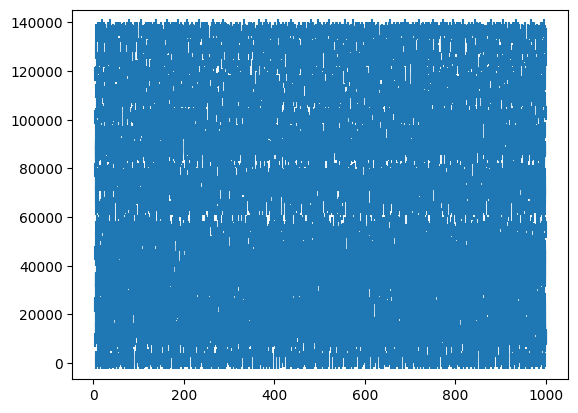

In [26]:
plt.figure()
plt.scatter(times_list[0].cpu(), idx_list[0].cpu(), s=100, marker='|')

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

In [27]:
df = utils.construct_dataframe(times_list, idx_list, i2flyid, 'P9_LC4s', sim_params['dt'])
df.to_parquet(config_dirs['path_res']+'P9_LC4s.parquet', compression='brotli')
ps = [
    config_dirs['path_res']+'P9s_100Hz_b.parquet',
    config_dirs['path_res']+'P9_LC4s.parquet',
]

df_spike = utils.load_exps(ps)
df_rate, df_rate_std = utils.get_rate(df_spike, t_run=1.0, n_run=sim_params['batch_size'], flyid2name=flyid2name)
df_rate.sort_values('P9s_100Hz_b', ascending=False, inplace=True)
df_rate

exp_name,name,P9_LC4s,P9s_100Hz_b
flyid,,,
720575940635872101,P9_right,62.700000,66.866667
720575940627652358,P9_left,26.466667,66.533333
720575940613626521,,3.266667,29.200000
720575940633901395,,6.800000,23.766667
720575940631924584,,15.433333,17.100000
...,...,...,...
720575940651833078,,44.666667,NaN
720575940652611745,,102.766667,NaN
720575940653310198,,1.233333,NaN


In [28]:
relevant_neurons = [neuron for neuron in output_neurons if neuron in df_rate.index]
display(df_rate.loc[relevant_neurons])

exp_name,name,P9_LC4s,P9s_100Hz_b
flyid,,,
720575940626730883,P9_oDN1_left,0.066667,6.133333
720575940620300308,P9_oDN1_right,NaN,1.633333
720575940627787609,DNa01_right,3.466667,NaN
720575940644438551,DNa01_left,20.466667,NaN
720575940629327659,DNa02_right,1.066667,0.633333
720575940604737708,DNa02_left,4.166667,10.166667
720575940616026939,MDN_1,0.033333,NaN
720575940631082808,MDN_2,0.733333,NaN
720575940640331472,MDN_3,0.500000,NaN


# Bilateral JO-CE

In [29]:
JO_EV = [720575940645106376,720575940615272415,720575940619869120,720575940620257345,720575940620382889,720575940630834683,720575940632449619,720575940634020508,720575940605530302,720575940607140035,720575940608742409,720575940615590843,720575940620410177,
         720575940621870618,720575940622344170,720575940623298559,720575940626042149,720575940627379333,720575940630080071,720575940632128031,
         720575940632307527,720575940634820703,]
JO_EDC=[720575940606154370,720575940605919334,720575940608884931,720575940616655989,720575940620543110,720575940622937528,720575940624799290,
        720575940626565455,720575940627941431,720575940627977457,
        720575940628160617,720575940629188251,720575940641921421]
JO_EDM=[720575940615972027,720575940618941037,720575940619729835,720575940627282279,720575940628903247,720575940604122982,720575940609486690,
        720575940609541917,
        720575940610018266,720575940611061526,720575940611273395,720575940611684787,720575940614060829,720575940616040587,720575940618599872,
        720575940618684481,720575940619663239,720575940619932654,720575940620919578,720575940621218729,720575940622271684,720575940622638276,
        720575940623312828,720575940625797617,720575940625962568,720575940626309438,720575940626666066,720575940627109991,720575940628101126,
        720575940628978450,720575940629055721,720575940629650997,720575940629985900,720575940630992557,720575940637054835,720575940637084762,
        720575940638664437,720575940646927668,720575940646929204,720575940659131009]
JO_EDP=[720575940609522461,720575940610261346,720575940613641915,720575940615469785,720575940616589878,720575940616951124,720575940619479979,
        720575940621218985,720575940628444667,720575940634634606,720575940640753267,720575940650244342]
JO_EVL=[720575940615573597,720575940615848788,720575940619083349,720575940621397417,720575940621625597,720575940622283912,720575940627049731,
        720575940629022149,720575940630122015,720575940630564179,720575940633153375,720575940637410869,720575940638681845,720575940621033477,
        720575940621776410,720575940621815690,720575940622234211,720575940622635817,720575940623897096,720575940626148354,720575940626540821,
        720575940628258715,720575940629743063,720575940630202624,720575940630544967,720575940633553820,720575940644036644]
JO_EVM=[720575940602132509,720575940602506208,720575940610759634,720575940614188149,720575940615809349,720575940615976891,720575940619341105,
        720575940621092534,720575940622419165,720575940622449388,720575940623108134,720575940624981436,720575940628192055,720575940630059847,
        720575940632767383,720575940639296189,720575940645466500,720575940611783464,720575940612307478,720575940612960552,720575940614351477,
        720575940617212134,720575940617434086,720575940618130334,720575940620249734,720575940620940276,720575940621010352,720575940621729757,
        720575940623437547,720575940624546062,720575940624686268,720575940625054647,720575940625605905,720575940626795909,720575940627585688,
        720575940630020111,720575940632175268,720575940634073183,720575940634891700,720575940637012196,720575940637243504,720575940639339392,
        720575940659426177]
JO_EVP=[720575940620444654,720575940631866508,720575940607853833,720575940611088563,720575940612773374,720575940613221928,720575940615024543,720575940615986459,720575940617811013,720575940618467195,720575940621442224,
        720575940622199977,720575940624915230,720575940625559358,720575940627104649,720575940627314088,720575940633058989,720575940636335735]
JO_CA=[720575940605800369,720575940608784579,720575940618135109,720575940626719101,720575940629296185,720575940636137591,720575940602720940,720575940610079857,720575940614427195,720575940616501787,720575940617156445,720575940625909962,720575940626241369,720575940629105658,720575940629138959,720575940636559534,720575940641372661]
JO_CL=[720575940626135548,720575940627751567,720575940604753437,720575940613971485,720575940614835362,720575940623399059,720575940630319671,720575940639082062]
JO_CM=[720575940607386307,720575940634512992,720575940614035485,720575940618901424,720575940630070343,720575940633443353,720575940635058612,720575940637632419,720575940625626000]
all_JOs = JO_EV+JO_EDC+JO_EDM+JO_EDP+JO_EVL+JO_EVM+JO_EVP+JO_CA+JO_CL+JO_CM

In [30]:
rates = torch.zeros(sim_params['batch_size'],len(flyid2i), device=device)
p9_neurons = [flyid2i[n] for n in P9s]
rates[:,p9_neurons] = 100.0
lc4_neurons = [flyid2i[n] for n in all_JOs]
rates[:,lc4_neurons] = 300.0

model = models.TorchModel(sim_params['batch_size'], weights.shape[0], sim_params['dt'], model_params, weights.to(device=device), device=device)
conductance, delay_buffer, spikes, v, refrac = model.state_init()
spike_times = torch.tensor([], device=device)
spike_idx = torch.tensor([], device=device, dtype=torch.int32)
generator = torch.Generator(device=device).manual_seed(42)

with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    times_list = []
    idx_list = []
    for b in range(sim_params['batch_size']):
        times_list.append(torch.tensor([], device=device))
        idx_list.append(torch.tensor([], device=device))
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)
        for b in range(sim_params['batch_size']):
            times_list[b], idx_list[b] = utils.get_spike_times(spikes[b,:], t, sim_params['dt'], times_list[b], idx_list[b])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation time: 181.53 seconds


Used 3.9514 GB


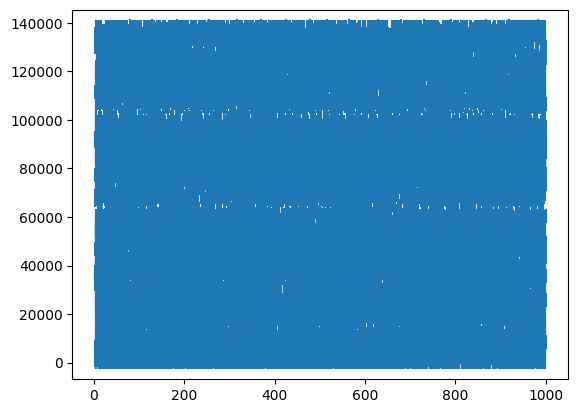

In [31]:
plt.figure()
plt.scatter(times_list[0].cpu(), idx_list[0].cpu(), s=100, marker='|')

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

In [32]:
df = utils.construct_dataframe(times_list, idx_list, i2flyid, 'P9_JO_CE_bilateral', sim_params['dt'])
df.to_parquet(config_dirs['path_res']+'P9_JO_CE_bilateral', compression='brotli')
ps = [
    config_dirs['path_res']+'P9s_100Hz_b.parquet',
    config_dirs['path_res']+'P9_JO_CE_bilateral',
]

df_spike = utils.load_exps(ps)
df_rate, df_rate_std = utils.get_rate(df_spike, t_run=1.0, n_run=sim_params['batch_size'], flyid2name=flyid2name)
df_rate.sort_values('P9s_100Hz_b', ascending=False, inplace=True)
df_rate

exp_name,name,P9_JO_CE_bilateral,P9s_100Hz_b
flyid,,,
720575940635872101,P9_right,67.800000,66.866667
720575940627652358,P9_left,66.166667,66.533333
720575940613626521,,20.866667,29.200000
720575940633901395,,23.233333,23.766667
720575940631924584,,38.733333,17.100000
...,...,...,...
720575940659131009,,126.166667,NaN
720575940659426177,,126.000000,NaN
720575940660235649,,60.566667,NaN


In [33]:
relevant_neurons = [neuron for neuron in output_neurons if neuron in df_rate.index]
display(df_rate.loc[relevant_neurons])

exp_name,name,P9_JO_CE_bilateral,P9s_100Hz_b
flyid,,,
720575940626730883,P9_oDN1_left,18.100000,6.133333
720575940620300308,P9_oDN1_right,1.666667,1.633333
720575940629327659,DNa02_right,0.400000,0.633333
720575940604737708,DNa02_left,12.733333,10.166667
720575940616185531,aDN1_right,20.233333,NaN


# Olfaction: Aversive -> Repulsion

In [34]:
Or56a=[720575940659222657,720575940641403021,720575940624211470,720575940616536209,720575940615427734,720575940628380827,720575940654069409,720575940613671330,720575940644590116,720575940612972328,720575940627318696,720575940627805096,720575940632190765,720575940633031085,720575940634955188,720575940621106102,720575940615923131,720575940608928324,720575940631467591,720575940622553420,720575940628086607,720575940626357586,720575940632041043,720575940618946901,720575940616095318,720575940626411097,720575940634614367,720575940603832288,720575940620055905,720575940609633378,720575940637704676,720575940638202852,720575940622713578,720575940635705963,720575940629830508,720575940630257772,720575940619539182,720575940612019442,720575940639931893]
rates = torch.zeros(sim_params['batch_size'],len(flyid2i), device=device)
p9_neurons = [flyid2i[n] for n in P9s]
rates[:,p9_neurons] = 100.0
or56_neurons = [flyid2i[n] for n in Or56a]
rates[:,or56_neurons] = 300.0

model = models.TorchModel(sim_params['batch_size'], weights.shape[0], sim_params['dt'], model_params, weights.to(device=device), device=device)
conductance, delay_buffer, spikes, v, refrac = model.state_init()
spike_times = torch.tensor([], device=device)
spike_idx = torch.tensor([], device=device, dtype=torch.int32)
generator = torch.Generator(device=device).manual_seed(42)

with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    times_list = []
    idx_list = []
    for b in range(sim_params['batch_size']):
        times_list.append(torch.tensor([], device=device))
        idx_list.append(torch.tensor([], device=device))
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)
        for b in range(sim_params['batch_size']):
            times_list[b], idx_list[b] = utils.get_spike_times(spikes[b,:], t, sim_params['dt'], times_list[b], idx_list[b])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation time: 181.55 seconds


Used 4.0040 GB


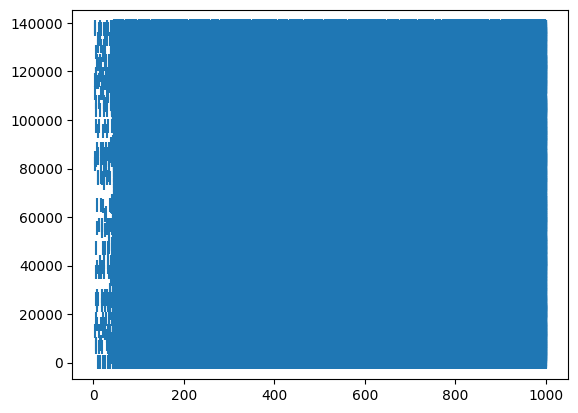

In [35]:
plt.figure()
plt.scatter(times_list[0].cpu(), idx_list[0].cpu(), s=100, marker='|')

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

In [36]:
df = utils.construct_dataframe(times_list, idx_list, i2flyid, 'P9_Or56a', sim_params['dt'])
df.to_parquet(config_dirs['path_res']+'P9_Or56a', compression='brotli')
ps = [
    config_dirs['path_res']+'P9s_100Hz_b.parquet',
    config_dirs['path_res']+'Sugar_200Hz.parquet',
    config_dirs['path_res']+'Sugar_and_bitter.parquet',
    config_dirs['path_res']+'P9_LC4s.parquet',
    config_dirs['path_res']+'P9_JO_CE_bilateral.parquet',
    config_dirs['path_res']+'P9_Or56a.parquet',
]

df_spike = utils.load_exps(ps)
df_rate, df_rate_std = utils.get_rate(df_spike, t_run=1.0, n_run=sim_params['batch_size'], flyid2name=flyid2name)
df_rate.sort_values('P9s_100Hz_b', ascending=False, inplace=True)
relevant_neurons = [neuron for neuron in output_neurons if neuron in df_rate.index]
display(df_rate.loc[relevant_neurons].fillna(0))

exp_name,name,P9_JO_CE_bilateral,P9_LC4s,P9_Or56a,P9s_100Hz_b,Sugar_200Hz,Sugar_and_bitter
flyid,,,,,,,
720575940626730883,P9_oDN1_left,18.633333,0.066667,0.500000,6.133333,0.000000,0.0
720575940620300308,P9_oDN1_right,1.700000,0.000000,0.500000,1.633333,0.000000,0.0
720575940627787609,DNa01_right,0.000000,3.466667,18.100000,0.000000,0.000000,0.0
720575940644438551,DNa01_left,0.000000,20.466667,8.600000,0.000000,0.066667,0.0
720575940629327659,DNa02_right,0.433333,1.066667,50.500000,0.633333,0.000000,0.0
720575940604737708,DNa02_left,12.900000,4.166667,1.000000,10.166667,0.000000,0.0
720575940616026939,MDN_1,0.000000,0.033333,0.000000,0.000000,0.000000,0.0
720575940631082808,MDN_2,0.000000,0.733333,0.000000,0.000000,0.000000,0.0
720575940640331472,MDN_3,0.000000,0.500000,0.000000,0.000000,0.000000,0.0


In [37]:
df_rate.to_csv(config_dirs['path_res']+'df_rate.csv')
df_spike

,t,trial,flywire_id,exp_name
0,0.950000,0,720575940627652358,P9s_100Hz_b
1,2.030000,0,720575940635872101,P9s_100Hz_b
2,2.720000,0,720575940635872101,P9s_100Hz_b
3,4.100000,0,720575940635872101,P9s_100Hz_b
4,4.570000,0,720575940631924584,P9s_100Hz_b
...,...,...,...,...
13420459,99.980003,29,720575940634195448,P9_Or56a
13420460,99.980003,29,720575940635116639,P9_Or56a
13420461,99.980003,29,720575940638818357,P9_Or56a
13420462,99.980003,29,720575940644598819,P9_Or56a
